# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create one step forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-10-10 08:32:00.194560: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 08:32:00.208491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 08:32:00.222258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 08:32:00.226060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 08:32:00.236603: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
import unittests

## Generating the data

First things first, you will need to generate your time series data. 

The next cell includes a bunch of helper functions to generate and plot the time series. These are very similar to those you saw on Week 1.

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Now, define a function to generate the time series, using the functions from the previous cell. This function should return a time series that has trend, seasonality and noise. 

In [3]:
def generate_time_series():
    """ Creates timestamps and values of the time series """
    
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

## Defining some useful global variables

Next, you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length of the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**


In [4]:
# Save all global variables
SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

Finally, put everything together and create the times series you will use for this assignment. 

In [5]:
# Create the time series
TIME, SERIES = generate_time_series()

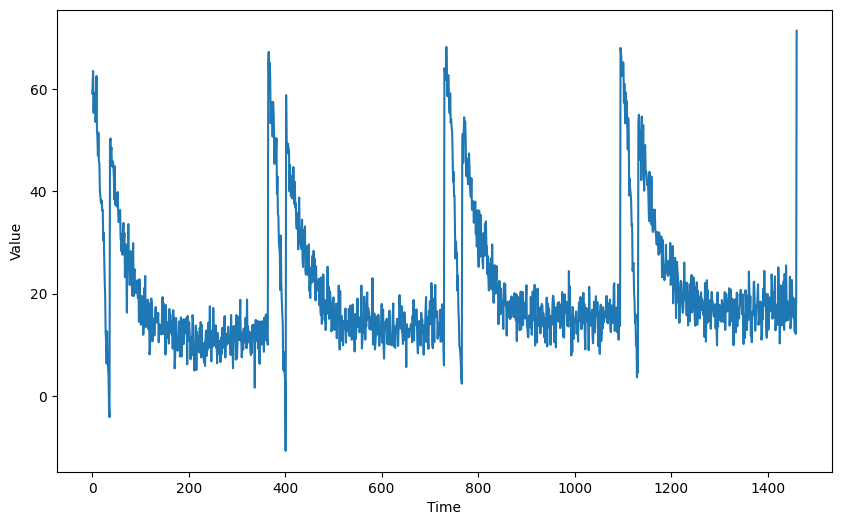

In [6]:
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Splitting the data

As usual, you will need a function to split the data between train and validation sets. Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [7]:
def train_val_split(time, series):

    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

## Processing the data

### Exercise 1: windowed_dataset

As you saw on the lectures, you can feed the data for training by creating a TF Dataset with the appropriate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. Remember you can do all these using the different methods of the `tf.data.Dataset` object. Next, complete the `windowed_dataset` function below that effectively pre-processes your time series and returns a TF Dataset.

This function receives a `series` and a `window_size`, and returns a TF Dataset. You should already be familiar with `tf.data.Dataset` objects from the this week's lectures, but be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) if you need any help.

In [9]:
# GRADED FUNCTION: windowed_dataset
def windowed_dataset(series, window_size, shuffle=True):
    """Create a windowed dataset

    Args:
        series (np.ndarray): time series
        window_size (int): length of window to use for prediction
        shuffle (bool): (For testing purposes) Indicates whether to shuffle data before batching or not. Defaults to True

    Returns:
        td.data.Dataset: windowed dataset
    """
    
    ### START CODE HERE ###
    # Create dataset from the series. 
    # HINT: use an appropriate method from the tf.data.Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle it
    if shuffle:  # For testing purposes
        dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE) 
    
    # Split it into the features and labels. 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(BATCH_SIZE)
    
    ### END CODE HERE ###
    
    return dataset

To test your function you will be using a `window_size` of 10 which means that you will use 10 consecutive values to predict the next one. You will also set the parameter `shuffle=False`. Given this, the first element of the batch of features should be identical to the first 15 elements of the `series_train`, and the batch of labels should be equal to elements 10 through 42 of the `series_train`.

In [10]:
# Try out your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=10,shuffle= False)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"First element in batch_of_features is equal to first 10 elements in the series: {np.allclose(batch_of_features.numpy()[0].flatten(), series_train[:10])}\n")
print(f"batch_of_labels is equal to the first 32 values after the window_lenght of 10): {np.allclose(batch_of_labels.numpy(), series_train[10:BATCH_SIZE+10])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True


I0000 00:00:1728560063.108401   58052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728560063.276848   58052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728560063.276895   58052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728560063.281697   58052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728560063.281751   58052 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True
```

Now plot the first item in the batch. You will be displayng the 20 features, followed by the label, which is the value you want to predict. 

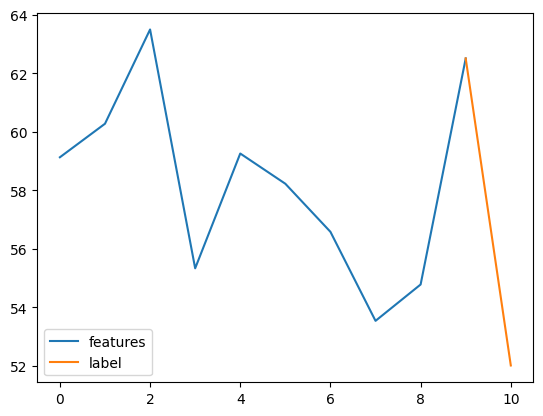

In [11]:
plt.plot(np.arange(10), batch_of_features[0].numpy(), label='features')
plt.plot(np.arange(9,11), [batch_of_features[0].numpy()[-1], batch_of_labels[0].numpy()], label='label')
plt.legend()

Now that you have tested your `windowed_dataset` function, use it to create your train dataset. For that, just run the cell below

In [12]:
# Apply the processing to the whole training series
train_dataset = windowed_dataset(series_train, WINDOW_SIZE)

In [ ]:
# Test your code!
unittests.test_windowed_dataset(windowed_dataset)

## Defining the model architecture

### Exercise 2: create_model 

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you model architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Remember that this time you are predicting the values of a time series, so use an appropriate loss for this task. There are many you can choose for, but for grading purposes, please stick to 'mse'. 

Hint:
- You will only need `Dense` layers.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.



In [37]:
# GRADED FUNCTION: create_model
def create_model(window_size):
    """Create model for predictions
    Args:
        window_size (int): length of window to use for prediction

    Returns:
        tf.keras.Model: model
    """
    ### START CODE HERE ###

    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(window_size,)),
       tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9))
    
    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [38]:
# Get the untrained model
model = create_model(WINDOW_SIZE)

In [ ]:
# Check the parameter count against a reference solution
unittests.parameter_count(model)

In [39]:
example_batch = train_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-10-10 08:42:41.432833: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 08:42:41.721155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:41.721238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


predictions have shape: (32, 1)


**Expected output:**
```
predictions have shape: (NUM_BATCHES, 1)

Where NUM_BATCHES is the number of batches you have set to your dataset.
```

Before going any further, check that the input and output dimensions of your model are correct. Do this by running the cell below:

In [40]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

Model input shape: (None, 20)
Model output shape: (None, 1)


You can also print a summary of your model to see what the architecture looks like. 

In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Test your code!
unittests.test_create_model(create_model, windowed_dataset)

In [42]:
# Train it
history = model.fit(train_dataset, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 67.8762
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.0181 
Epoch 3/100


2024-10-10 08:42:50.487979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:50.488056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:50.651436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:50.651488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.4772
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.2627
Epoch 5/100


2024-10-10 08:42:50.810445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:50.810500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:50.969484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:50.969541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.1084
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.4697
Epoch 7/100


2024-10-10 08:42:51.132082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:51.132136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:51.291736: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:51.291792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.6694
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.7694
Epoch 9/100


2024-10-10 08:42:51.457744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:51.457798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:51.621723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:51.621783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9760
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.9098
Epoch 11/100


2024-10-10 08:42:51.788307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:51.788362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:51.948793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:51.948846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.5369
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.1217
Epoch 13/100


2024-10-10 08:42:52.113072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:52.113124: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:52.276002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:52.276062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.9720
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.8894 
Epoch 15/100


2024-10-10 08:42:52.445145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:52.445198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:52.612870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:52.612928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.6896
Epoch 16/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.6540
Epoch 17/100


2024-10-10 08:42:52.773762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:52.773820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:52.934480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:52.934536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.1133
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.6879
Epoch 19/100


2024-10-10 08:42:53.101261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:53.101316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:53.266831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:53.266887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.9464
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.0123
Epoch 21/100


2024-10-10 08:42:53.434206: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:53.434259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:53.596870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:53.596924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.5351
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.6500
Epoch 23/100


2024-10-10 08:42:53.768110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:53.768167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:53.932388: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:53.932442: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.5739
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.6907
Epoch 25/100


2024-10-10 08:42:54.099780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:54.099838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:54.271019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:54.271079: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4868
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.1584
Epoch 27/100


2024-10-10 08:42:54.436948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:54.437004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:54.602215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:54.602271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.9533 
Epoch 28/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.3892
Epoch 29/100


2024-10-10 08:42:54.770051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:54.770108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:54.935141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:54.935198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.3506
Epoch 30/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.6123
Epoch 31/100


2024-10-10 08:42:55.106045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:55.106101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:55.272410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:55.272469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.2406
Epoch 32/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.9845
Epoch 33/100


2024-10-10 08:42:55.440566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:55.440622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:55.605226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:55.605285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.7930
Epoch 34/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.6095
Epoch 35/100


2024-10-10 08:42:55.803968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:55.804046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:55.983929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:55.983987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.1147
Epoch 36/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.6085
Epoch 37/100


2024-10-10 08:42:56.149957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:56.150016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:56.315046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:56.315100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.8209
Epoch 38/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.5587
Epoch 39/100


2024-10-10 08:42:56.484874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:56.484927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:56.648862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:56.648919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.5670
Epoch 40/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.0510
Epoch 41/100


2024-10-10 08:42:56.827537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:56.827600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:56.996090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:56.996157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.3060
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.0563
Epoch 43/100


2024-10-10 08:42:57.170409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:57.170467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:57.335926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:57.336002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.7020
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.6486
Epoch 45/100


2024-10-10 08:42:57.508354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:57.508409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:57.677055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:57.677114: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.8557
Epoch 46/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9999
Epoch 47/100


2024-10-10 08:42:57.850021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:57.850078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:58.024337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:58.024397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.6305
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.4671
Epoch 49/100


2024-10-10 08:42:58.190892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:58.190952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:58.360636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:58.360697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1513
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.2927
Epoch 51/100


2024-10-10 08:42:58.535866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:58.535923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:58.703692: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:58.703750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.4100
Epoch 52/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.0855
Epoch 53/100


2024-10-10 08:42:58.878142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:58.878198: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:59.046774: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 08:42:59.046819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:59.046841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.6216
Epoch 54/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.4553
Epoch 55/100


2024-10-10 08:42:59.217584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:59.217646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:59.380585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:59.380645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.1116
Epoch 56/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.8280
Epoch 57/100


2024-10-10 08:42:59.549323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:59.549380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:42:59.716137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:59.716191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.5943
Epoch 58/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.8798
Epoch 59/100


2024-10-10 08:42:59.890254: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:42:59.890315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:00.057104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:00.057162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.6709
Epoch 60/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.3427
Epoch 61/100


2024-10-10 08:43:00.224030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:00.224101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:00.390848: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:00.390912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.4351
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.2786 
Epoch 63/100


2024-10-10 08:43:00.559568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:00.559623: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:00.728452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:00.728507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.0074
Epoch 64/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7323
Epoch 65/100


2024-10-10 08:43:00.908463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:00.908520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:01.076966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:01.077020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6989
Epoch 66/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.5033
Epoch 67/100


2024-10-10 08:43:01.244542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:01.244618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:01.413759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:01.413815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.8840
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.1943
Epoch 69/100


2024-10-10 08:43:01.585425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:01.585482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:01.750194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:01.750251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.3238
Epoch 70/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.1172
Epoch 71/100


2024-10-10 08:43:01.928554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:01.928619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:02.097083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:02.097137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.2338
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7984
Epoch 73/100


2024-10-10 08:43:02.270158: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:02.270215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:02.436175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:02.436232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4552
Epoch 74/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.8738
Epoch 75/100


2024-10-10 08:43:02.603564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:02.603617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:02.768071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:02.768129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2697
Epoch 76/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.7315
Epoch 77/100


2024-10-10 08:43:02.935279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:02.935336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:03.105573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:03.105627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.4769
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.3572
Epoch 79/100


2024-10-10 08:43:03.281639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:03.281697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:03.450373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:03.450433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.0045
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2139
Epoch 81/100


2024-10-10 08:43:03.620498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:03.620556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:03.783584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:03.783639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.8992
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9842
Epoch 83/100


2024-10-10 08:43:03.949905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:03.949963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:04.123544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:04.123600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.1542
Epoch 84/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.4353
Epoch 85/100


2024-10-10 08:43:04.292580: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:04.292640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:04.462193: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:04.462250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.7963
Epoch 86/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.3958
Epoch 87/100


2024-10-10 08:43:04.633416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:04.633474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:04.798461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:04.798519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.9408
Epoch 88/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.1258
Epoch 89/100


2024-10-10 08:43:04.968831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:04.968885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:05.141253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:05.141310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.8517
Epoch 90/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.7744
Epoch 91/100


2024-10-10 08:43:05.311502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:05.311559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:05.478480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:05.478538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.6229
Epoch 92/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.7136
Epoch 93/100


2024-10-10 08:43:05.655113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:05.655167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:05.818784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:05.818844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.2076
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.0097
Epoch 95/100


2024-10-10 08:43:05.989014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:05.989070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:06.161672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:06.161730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.0162
Epoch 96/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.0321
Epoch 97/100


2024-10-10 08:43:06.335954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:06.336014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:06.502035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:06.502090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.9150
Epoch 98/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.5231
Epoch 99/100


2024-10-10 08:43:06.678175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:06.678230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:06.841749: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:06.841807: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.3414
Epoch 100/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.9142


2024-10-10 08:43:07.010723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:07.010781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460
2024-10-10 08:43:07.180553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10507182286835943745
2024-10-10 08:43:07.180609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10562588140938311460


Now go ahead and plot the training loss so you can monitor the learning process.

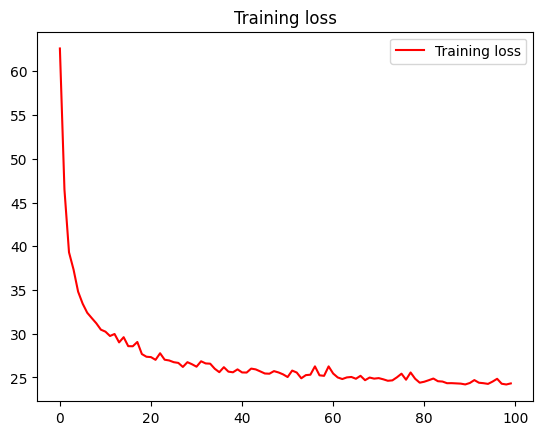

In [43]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [44]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

You will also be generating `predict_forecast` function, that simply computes predictions for all values in the validation data. 

In [45]:
def generate_forecast(model, series, window_size):
    forecast = []
    for time in range(SPLIT_TIME, len(series)):
        pred = model.predict(series[time-window_size:time][np.newaxis], verbose=0)
        forecast.append(pred[0][0])
    return forecast

Now, go ahead and make the predictions. This run should take no more time than the actual training.  

In [46]:
# Save the forecast
dnn_forecast = generate_forecast(model, SERIES, WINDOW_SIZE)

You can now plot the true series, and the predicted series in order to get a visual estimate of how good your model is doing.

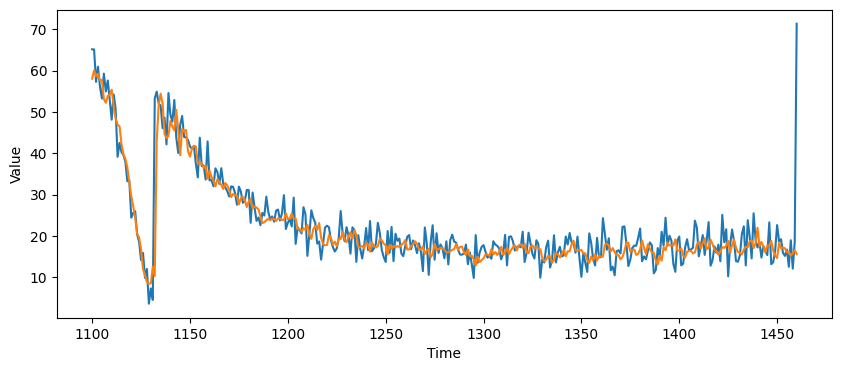

In [47]:
# Plot it
plt.figure(figsize=(10, 4))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/forecast.png" width="800">
</div>

Finally, go ahead and compute the MSE and MAE metrics using the `compute_metrics` function you defined earlier.

In [48]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 26.71, mae: 3.10 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the MSE in a binary file which will be used for grading and after doing so, submit your assigment for grading.

In [ ]:
# ONLY RUN THIS CELL IF YOUR MSE ACHIEVED THE DESIRED MSE LEVEL
# Save your model 
model.save('trained_model.keras')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**